The University of Tokyo

Special Lectures in Information Science Ⅱ

Introduction to Near-Term Quantum Computing

# 6. Quantum Algorithms: Variational quantum algorithms

Takashi Imamichi (May 24, 2024)

In [1]:
import qiskit

qiskit.__version__

'1.0.2'

## Exercise

Compute the minimum eigenvalue of $Z \otimes Z$ with VQE.

In [3]:
import numpy as np
from scipy.optimize import minimize

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler, Estimator

In [5]:
z2 = SparsePauliOp("ZZ")
print(z2)
print(z2.to_matrix())

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [6]:
# compute eigenvalues with numpy
result = np.linalg.eigh(z2.to_matrix())
print("Eigenvalues:", result.eigenvalues)

Eigenvalues: [-1. -1.  1.  1.]


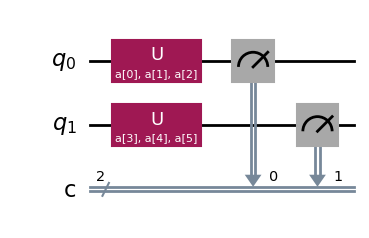

In [7]:
# define a variational form
param = ParameterVector("a", 6)
qc = QuantumCircuit(2, 2)
qc.u(param[0], param[1], param[2], 0)
qc.u(param[3], param[4], param[5], 1)
qc_estimator = qc.copy()
qc.measure([0, 1], [0, 1])
qc.draw("mpl")

In [9]:
sampler = Sampler()
estimator = Estimator()

In [10]:
# compute probabilities of bitstrings with a random parameter values by Sampler
result = sampler.run(qc, [1, 2, 3, 4, 5, 6]).result()
result

SamplerResult(quasi_dists=[{0: 0.13337338235898, 1: 0.039804807209214, 2: 0.63677777057509, 3: 0.190044039856716}], metadata=[{}])

In [11]:
# compute the expectation value of ZZ based on the probabilities
prob = result.quasi_dists[0]
prob.get(0, 0) - prob.get(1, 0) - prob.get(2, 0) + prob.get(3, 0)

-0.3531651555686095

In [12]:
# verify the expectation value of ZZ with Estimator
result = estimator.run(qc_estimator, z2, [1, 2, 3, 4, 5, 6]).result()
result

EstimatorResult(values=array([-0.35316516]), metadata=[{}])

In [13]:
# define a cost function to look for the minimum eigenvalue of ZZ
def cost(x):
    result = sampler.run(qc, x).result()
    prob = result.quasi_dists[0]
    expval = prob.get(0, 0) - prob.get(1, 0) - prob.get(2, 0) + prob.get(3, 0)
    print(prob, expval)
    return expval

In [14]:
# minimize the cost function with scipy's minimize
min_result = minimize(cost, [0, 0, 0, 0, 0, 0], method="COBYLA", tol=1e-8)
min_result

{0: 1.0} 1.0
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.77015115293407, 1: 0.22984884706593} 0.5403023058681397
{0: 0.593132798365677, 1: 0.177018354568393, 2: 0.177018354568393, 3: 0.052830492497537} 0.2919265817264289
{0: 0.593132798365677, 1: 0.177018354568393, 2: 0.177018354568393, 3: 0.052830492497537} 0.29192658172642894
{0: 0.593132798365677, 1: 0.177018354568393, 2: 0.177018354568393, 3: 0.052830492497537} 0.2919265817264289
{0: 0.190553115473457, 1: 0.357095221094721, 2: 0.157394833510653, 3: 0.29495682992117} -0.028980109210747396
{0: 0.016633330903608, 1: 0.185784342816186, 2: 0.065539982315244, 3: 0.732042343964962} 0.49735134973714035
{0: 0.072402130935048, 1: 0.293743341512295, 2: 0.125339303503857, 3: 0.5085152240488} 0.1618347099676969
{0: 0.190553115473457, 1: 0.357095221094721, 2: 0.157394833510653, 3: 0.29495682992117} -0.028980109210747618
{0: 0.072402130935048, 1: 0.2937433415122

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.9999999999999998
       x: [ 3.142e+00  3.086e-01 -1.633e-01 -1.369e-08 -2.451e-02
           -9.014e-01]
    nfev: 176
   maxcv: 0.0

In [15]:
# check probabilities of bitstrings with the optimal parameters
result = sampler.run(qc, min_result.x).result()
result

SamplerResult(quasi_dists=[{1: 1.0}], metadata=[{}])